In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
# to split dataset
from sklearn.model_selection import train_test_split
# to import dataset
from sklearn.datasets import fetch_lfw_people
%matplotlib inline
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "data/lfw/"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             seed=42)

Found 13233 files belonging to 5749 classes.
Using 10587 files for training.


2022-06-22 15:51:20.127498: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 13233 files belonging to 5749 classes.
Using 2646 files for validation.


In [3]:
classes = 5749

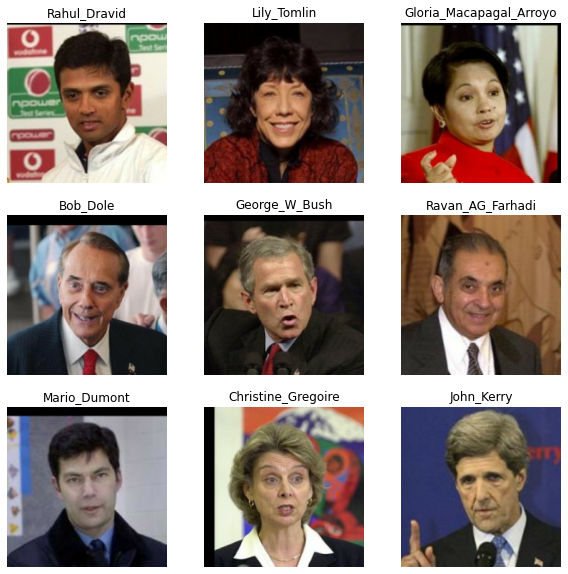

In [4]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [5]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [6]:
IMG_SHAPE = IMG_SIZE + (3,)
print(IMG_SHAPE, IMG_SIZE)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

(224, 224, 3) (224, 224)


In [7]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [9]:
#Shows the different label probabilities in one tensor 
label_batch

<tf.Tensor: shape=(32,), dtype=int32, numpy=
array([3160, 3957, 3856, 1910, 4089, 1336, 1842, 4487,  280, 3807, 5007,
       2067, 4628, 5548, 2755, 5360, 1933,  507, 3014, 3273, 5526, 4173,
       1871,  631,  220, 4274, 2683,  341, 4053, 5585,  962, 3644],
      dtype=int32)>

In [10]:
base_model.trainable = False
image_var = tf.Variable(preprocess_input(image_batch))
pred = base_model(image_var)

tf.keras.applications.mobilenet_v2.decode_predictions(pred.numpy(), top=2)

[[('n03630383', 'lab_coat', 0.9066226),
  ('n04591157', 'Windsor_tie', 0.0196742)],
 [('n04591157', 'Windsor_tie', 0.0753835), ('n04584207', 'wig', 0.07293905)],
 [('n04591157', 'Windsor_tie', 0.84074813), ('n04350905', 'suit', 0.04050648)],
 [('n02790996', 'barbell', 0.13986294),
  ('n09835506', 'ballplayer', 0.08230784)],
 [('n02992529', 'cellular_telephone', 0.0936049),
  ('n03759954', 'microphone', 0.03758126)],
 [('n03759954', 'microphone', 0.7036041),
  ('n02992529', 'cellular_telephone', 0.027949175)],
 [('n04591157', 'Windsor_tie', 0.73438966), ('n04350905', 'suit', 0.077943)],
 [('n04456115', 'torch', 0.08598578), ('n04532106', 'vestment', 0.06360679)],
 [('n04591157', 'Windsor_tie', 0.58419913), ('n04350905', 'suit', 0.1895693)],
 [('n04591157', 'Windsor_tie', 0.5220199), ('n04350905', 'suit', 0.36598167)],
 [('n02669723', 'academic_gown', 0.1165938),
  ('n03970156', 'plunger', 0.103270575)],
 [('n04591157', 'Windsor_tie', 0.0502178),
  ('n02948072', 'candle', 0.024095528)],


In [11]:
def celeb_model(image_shape=IMG_SIZE):
    ''' Define a tf.keras model for binary classification out of the MobileNetV2 model
    Arguments:
        image_shape -- Image width and height
        data_augmentation -- data augmentation function
    Returns:
    Returns:
        tf.keras.model
    '''
    
    
    input_shape = image_shape + (3,)
    
    ### START CODE HERE
    
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape,
                                                   include_top=False, # <== Important!!!!
                                                   weights='imagenet') # From imageNet
    
    # freeze the base model by making it non trainable
    base_model.trainable = False 

    # create the input layer (Same as the imageNetv2 input size)
    inputs = tf.keras.Input(shape=input_shape) 
    
    # apply data augmentation to the inputs
    # x = data_augmentation(inputs)
    
    # data preprocessing using the same weights the model was trained on
    x = preprocess_input(inputs) 
    
    # set training to False to avoid keeping track of statistics in the batch norm layer
    x = base_model(x, training=False) 
    
    # add the new Binary classification layers
    # use global avg pooling to summarize the info in each channel
    x = layers.GlobalAveragePooling2D()(x) 
    # include dropout with probability of 0.2 to avoid overfitting
    x = layers.Dropout(0.2)(x)
        
    # use a prediction layer with one neuron (as a binary classifier only needs one)
    outputs = layers.Dense(classes, activation = 'softmax')(x)
    
    ### END CODE HERE
    
    model = tf.keras.Model(inputs, outputs)
    
    return model

In [12]:
model2 = celeb_model()

In [13]:
base_learning_rate = 0.001
model2.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [14]:
initial_epochs = 2
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/2


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


331/331 [==============================] - 255s 761ms/step - loss: 8.5481 - accuracy: 0.0815 - val_loss: 7.9943 - val_accuracy: 0.1198
Epoch 2/2
331/331 [==============================] - 253s 763ms/step - loss: 3.2665 - accuracy: 0.4502 - val_loss: 8.1252 - val_accuracy: 0.1429


In [15]:
class_names

['AJ_Cook',
 'AJ_Lamas',
 'Aaron_Eckhart',
 'Aaron_Guiel',
 'Aaron_Patterson',
 'Aaron_Peirsol',
 'Aaron_Pena',
 'Aaron_Sorkin',
 'Aaron_Tippin',
 'Abba_Eban',
 'Abbas_Kiarostami',
 'Abdel_Aziz_Al-Hakim',
 'Abdel_Madi_Shabneh',
 'Abdel_Nasser_Assidi',
 'Abdoulaye_Wade',
 'Abdul_Majeed_Shobokshi',
 'Abdul_Rahman',
 'Abdulaziz_Kamilov',
 'Abdullah',
 'Abdullah_Ahmad_Badawi',
 'Abdullah_Gul',
 'Abdullah_Nasseef',
 'Abdullah_al-Attiyah',
 'Abdullatif_Sener',
 'Abel_Aguilar',
 'Abel_Pacheco',
 'Abid_Hamid_Mahmud_Al-Tikriti',
 'Abner_Martinez',
 'Abraham_Foxman',
 'Aby_Har-Even',
 'Adam_Ant',
 'Adam_Freier',
 'Adam_Herbert',
 'Adam_Kennedy',
 'Adam_Mair',
 'Adam_Rich',
 'Adam_Sandler',
 'Adam_Scott',
 'Adel_Al-Jubeir',
 'Adelina_Avila',
 'Adisai_Bodharamik',
 'Adolfo_Aguilar_Zinser',
 'Adolfo_Rodriguez_Saa',
 'Adoor_Gopalakarishnan',
 'Adrian_Annus',
 'Adrian_Fernandez',
 'Adrian_McPherson',
 'Adrian_Murrell',
 'Adrian_Nastase',
 'Adriana_Lima',
 'Adriana_Perez_Navarro',
 'Adrianna_Zuzic',
 

In [16]:
# UNQ_C3
base_model = model2.layers[3]
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 120

### START CODE HERE

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False
    
# Define a BinaryCrossentropy loss function. Use from_logits=True
loss_function=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(lr=0.1*base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

### END CODE HERE

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

Number of layers in the base model:  154


In [17]:
fine_tune_epochs = 5
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=5,
                         validation_data=validation_dataset)

Epoch 6/7
172/331 [==============>...............] - ETA: 2:06 - loss: 0.5301 - accuracy: 0.8765

In [ ]:
model2.save("models/1stMobileNetV2")